In [1]:
import ray
ray.init()

2020-08-10 22:52:39,048	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-08-10 22:52:39,050	INFO resource_spec.py:216 -- Starting Ray with 207.52 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.10.215',
 'redis_address': '192.168.10.215:62563',
 'object_store_address': '/tmp/ray/session_2020-08-10_22-52-39_047823_53888/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-08-10_22-52-39_047823_53888/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-08-10_22-52-39_047823_53888'}

In [2]:
# Generate synthetic data to evaluate Good-Turing stability of mutex structure

d = 100000
expected_nnz = 50

import numpy as np
import os
np.random.seed(1234)

def sample_verts(n, d, sz, max_ratio, outf):
    """
    sample subsets of integer [0, d) of expected size sz
    such that the probability of a particular integer being
    drawn is independent of all others, but the maximum
    ratio of the probabilities of a particular integer
    being drawn are at most max_ratio (well, a little bit smaller)
    
    prints a binary frame size n x (d + 1) (prepended
    with a random equiprobable binary vector) to outfile
    
    returns min prob, max prob, avg incidence for each vec
    """
    
    # choose geometric progression for probabilities
    # lo * (max_ratio)^(0/d), lo * (max_ratio)^(1/d), ..., lo * max_ratio^((d-1)/d)
    # need sum to equal sz
    # sum is lo * (1 - max_ratio) / (1 - max_ratio^(1/d))
    if max_ratio > 1:
        corr = np.expm1(np.log(max_ratio) / d)
        ll = np.log(sz) - np.log(max_ratio - 1)
        # ll + log(corr) = log(lo)
        probs = ll + np.arange(d) * np.log(max_ratio) / d
        probs = np.exp(probs) * corr
    else:
        probs = np.ones(d) * (sz / d)
    
    for i, y in enumerate(np.random.choice(2, size=n)):
        print('1 ' if y else '0 ', file=outf, end='')
        np.savetxt(outf, np.flatnonzero(np.random.rand(d) < probs),
                   newline=' ', fmt='%d')
        print(file=outf)
        
    
        
    return probs[0], probs[-1], probs.sum(), probs

ratios = [4 ** i for i in range(11)]
ns = [10 * 1000]#, 100 * 1000]
print('d', d)
print('ns', ns)
print('ratios', ratios)

from subprocess import check_output

@ray.remote(num_cpus=1)
def gen_ratio(n, ratio):
    for t in ['train', 'test']:
        fn = f'data/synth_ratio{ratio}_n{n}.{t}'
        with open(fn, mode='w', buffering=1024 * 1024) as f:
            m, mm, e, p = sample_verts(n, d, expected_nnz, ratio, f)
            f.flush()
            os.fsync(f.fileno())
        wc = check_output(f'wc {fn}', shell=True, encoding='utf-8').strip()
        wc = wc.split()
        lines, words = [x for x in wc if x][:2]
        avg = int(words) / int(lines)
    print(f'ratio {ratio:5.1f} probs min {m:7.5f} max {mm:7.5f} avg words {avg}')
    return n, ratio, p

d 100000
ns [10000]
ratios [1, 4, 16, 64, 256, 1024, 4096, 16384, 65536, 262144, 1048576]


In [3]:
nrp = ray.get([gen_ratio.remote(n, ratio) for ratio in ratios for n in ns]);

(pid=53963) ratio 256.0 probs min 0.00001 max 0.00278 avg words 50.8632
(pid=53976) ratio 4096.0 probs min 0.00000 max 0.00416 avg words 50.9574
(pid=53943) ratio  16.0 probs min 0.00009 max 0.00148 avg words 51.0383
(pid=53957) ratio 262144.0 probs min 0.00000 max 0.00624 avg words 50.7586
(pid=53946) ratio 16384.0 probs min 0.00000 max 0.00485 avg words 50.9148
(pid=53973) ratio   4.0 probs min 0.00023 max 0.00092 avg words 50.9662
(pid=53962) ratio 1024.0 probs min 0.00000 max 0.00347 avg words 50.8876
(pid=53961) ratio   1.0 probs min 0.00050 max 0.00050 avg words 51.0889
(pid=53971) ratio 1048576.0 probs min 0.00000 max 0.00693 avg words 51.0182
(pid=53954) ratio  64.0 probs min 0.00003 max 0.00211 avg words 51.1154


In [40]:
nsamples = 100

@ray.remote(num_cpus=1)
def get_exp(nrp, colors):
    n, r, p = nrp
    
    p = np.insert(p, len(p), np.zeros(colors - (len(p) % colors)))
    
    samples = []
    for _ in range(nsamples):
        np.random.shuffle(p)
        ps = p.reshape(colors, -1)
        # each row in this matrix corresponds to a partition from a random bucketing
        # each item in each row is a Bernoulli for that feature appearing
        # we're interested in the expected number of collisions, defined precisely as
        # X = (number of active features) - (number of buckets with active features)
        # by tower property, we can condition on a shuffling of features, so we can look
        # at buckets individually.
        # for bucket i, let A_i be the active features in that bucket.
        # then the sum of (A_i - 1{A_i>0}) across i is equal to x
        # 
        # fix any i and let p_i be the vector of probabilities for each of the Bernoullis
        # in this bucket only (length == colors). Then A_i is PoissonBinomial(p_i) and
        # E[A_i - 1{A_i>0}] = E[A_i] - 1 + Prob{A_i = 0}
        #
        # I don't think there's a non-monte-carlo way of getting this expectation,
        # but the terms A_i above are essentially Poisson(||p_i||_1) since each
        # p_i has small entries, which could lead to a non-sampling approximation
        pzero = np.prod(1 - ps, axis=1)
        samples.append(np.sum(ps.sum(axis=1) - 1 + pzero))
    
    return np.mean(samples)

In [26]:
import pandas as pd

In [27]:
ns_bash = ' '.join(map(str, ns))
ratios_bash = ' '.join(map(str, ratios))

In [28]:
%%bash -s '{ns_bash}' '{ratios_bash}'

ns="$1"
ratios="$2"

budget=2048
for ratio in $ratios ; do
for n in $ns ; do
  echo "synth_ratio${ratio}_n${n}"
done
done | RAYON_NUM_THREADS=2 xargs -L1 -I {} -P $(nproc) bash -c "./csl/target/release/csl --budget $budget \
    --nofilter \
    --compress Identity --train ./data/{}.train --max-k 1 \
    --print-new-edges --valid ./data/{}.test > ./data/bound-log.{}.log"

In [29]:
%%bash -s '{ns_bash}' '{ratios_bash}'

ns="$1"
ratios="$2"

if true ; then

function exarr {
key=$1
value=$(grep "^$key" $2 | head -1)
value=${value#"$key"}
echo "\"$3\":" \""$value"\" ","
}

echo "["

for ratio in $ratios ; do
for n in 10000 ; do

dataset="synth_ratio${ratio}_n${n}"

logfile="data/bound-log.${dataset}.log"

echo "{"
echo "\"vertex_ratio\": $ratio,"
echo "\"n\": $n,"
exarr "greedy num colors" $logfile "greedy_colors"
exarr "filtered thresholded Good-Turing estimate" $logfile "good_turing_new_edge_estimator"
exarr "filtered thresholded actual new edge avg" $logfile "test_set_new_edges_per_example"
exarr "color collision count" $logfile "greedy_cc"
exarr "color collision std" $logfile "greedy_std"
#exarr "glauber collisions" $logfile "glauber_colors_cc"
echo "},"

done
done
echo "]"
# npm install -g relaxed-json
fi | rjson /dev/stdin > ./data/extracted-log.json

In [30]:
%%bash

head ./data/extracted-log.json

[
  {
    "vertex_ratio": 1,
    "n": 10000,
    "greedy_colors": " 79",
    "good_turing_new_edge_estimator": " [1185.8008]",
    "test_set_new_edges_per_example": " [1207.4076]",
    "greedy_cc": " 14.2582",
    "greedy_std": " 4.331481589479513"
  },


In [31]:
import json
with open('./data/extracted-log.json', 'r') as f:
    r = json.load(f)
df = pd.DataFrame.from_records(r)

#df['glauber_colors'] = df.glauber_colors_cc.map(lambda x: eval(x)[0][0])
#df['glauber_cc'] = df.glauber_colors_cc.map(lambda x: eval(x)[0][1])
df['good_turing_new_edge_estimator'] = df.good_turing_new_edge_estimator.map(lambda x: eval(x)[0])
df.greedy_colors = df.greedy_colors.astype(float)
df.greedy_cc = df.greedy_cc.astype(float)

df.head()

,vertex_ratio,n,greedy_colors,good_turing_new_edge_estimator,test_set_new_edges_per_example,greedy_cc,greedy_std
0,1,10000,79.0,1185.8008,[1207.4076],14.2582,4.331481589479513
1,4,10000,79.0,1160.0594,[1158.4572],14.0821,4.328759590229051
2,16,10000,80.0,1095.7386,[1077.3973],13.2493,4.149475811473061
3,64,10000,93.0,1020.3051,[993.594],11.8073,3.8766695384053573
4,256,10000,110.0,933.6138,[906.8957],10.4410,3.6216735082003155


In [38]:
def how_many_colors(nrp):
    n, r, _ = nrp
    ix = df.vertex_ratio == r
    assert int(ix.sum()) == 1
    ix = np.flatnonzero(ix)[0]
    return int(df.at[0, 'greedy_colors'])

In [41]:
expectations = ray.get([get_exp.remote(x, how_many_colors(x)) for x in nrp])
edf = pd.DataFrame.from_records([
    {'random_cc': e, 'vertex_ratio': r}
    for e, (_, r, _) in zip(expectations, nrp)
])
df = pd.merge(df, edf, on='vertex_ratio')

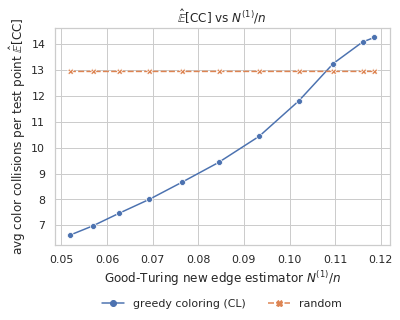

In [42]:
# switch with glauber-extended greedy (later)
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

ddf = df.copy()
ddf.rename(columns={
    'good_turing_new_edge_estimator': 'gte',
    'greedy_cc': 'greedy',
    'random_cc': 'random'
    }, inplace=True)
ddf['gte'] = ddf.gte / df.n

mdf = ddf[['gte', 'greedy', 'random']]
x = r'Good-Turing new edge estimator $N^{(1)}/n$'
y = r'avg color collisions per test point $\hat\mathbb{E}[\mathrm{CC}]$'
mdf = mdf.melt('gte', var_name='bucketing',  value_name=y)

# error bars need to be tediously manually plotted via
# matplotlib, and they're not visible (Too small) anyway
#sdf = ddf[['gte', 'greedy_std', 'random_cc_std']]
#sdf.rename(columns={'greedy_std': 'greedy', 'random_cc_std': 'random'}, inplace=True)
#sdf = sdf.melt('gte', var_name='bucketing',  value_name='std')

#ddf = pd.merge(mdf, sdf, on=['gte', 'bucketing'])
ddf = mdf
ddf.rename(columns={'gte': x}, inplace=True)
ddf['bucketing']= ddf.bucketing.map({'random': 'random', 'greedy': 'greedy coloring (CL)'})

sns.lineplot(data=ddf, x=x, y=y, hue='bucketing', style='bucketing', markers=True)

plt.title(r'$\hat\mathbb{E}[\mathrm{CC}]$ vs $N^{(1)}/n$')
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:]
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -.2), ncol=3, frameon=False)
plt.savefig('pics/ccgreedy.pdf',  bbox_inches='tight')
plt.show()